(25000, 3) Index(['Unnamed: 0', 'text', 'label'], dtype='object')
vocab: (294927, 2) Index(['word', 'count'], dtype='object')
num_tokens: 25852
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "Encoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (InputLayer)    [(None, 10)]              0         
                                                                 
 Embedding-Layer (Embedding  (None, 10, 60)            1551120   
 )                                                               
                                                                 
 Encoder-Batchnorm-1 (Batch  (None, 10, 60)            240       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)          

C:\Users\jayanti.prasad\Anaconda3\envs\aiml_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 15s 23ms/step - loss: 0.5120 - accuracy: 0.7480 - val_loss: 0.8982 - val_accuracy: 0.4984
Epoch 3/10
625/625 [==============================] - 17s 27ms/step - loss: 0.2783 - accuracy: 0.8826 - val_loss: 1.2642 - val_accuracy: 0.5040
Epoch 4/10
625/625 [==============================] - 18s 29ms/step - loss: 0.1306 - accuracy: 0.9492 - val_loss: 1.6558 - val_accuracy: 0.5014
Epoch 5/10
625/625 [==============================] - 19s 30ms/step - loss: 0.0598 - accuracy: 0.9803 - val_loss: 2.2160 - val_accuracy: 0.4976
Epoch 6/10
625/625 [==============================] - 15s 24ms/step - loss: 0.0310 - accuracy: 0.9910 - val_loss: 2.4563 - val_accuracy: 0.5018
Epoch 7/10
625/625 [==============================] - 14s 22ms/step - loss: 0.0202 - accuracy: 0.9945 - val_loss: 2.8128 - val_accuracy: 0.4980
Epoch 8/10
625/625 [==============================] - 14s 22ms/step - loss: 0.0161 - accuracy: 0.9956 - val_loss: 2.8743 - val_accuracy: 0.5034
Epo

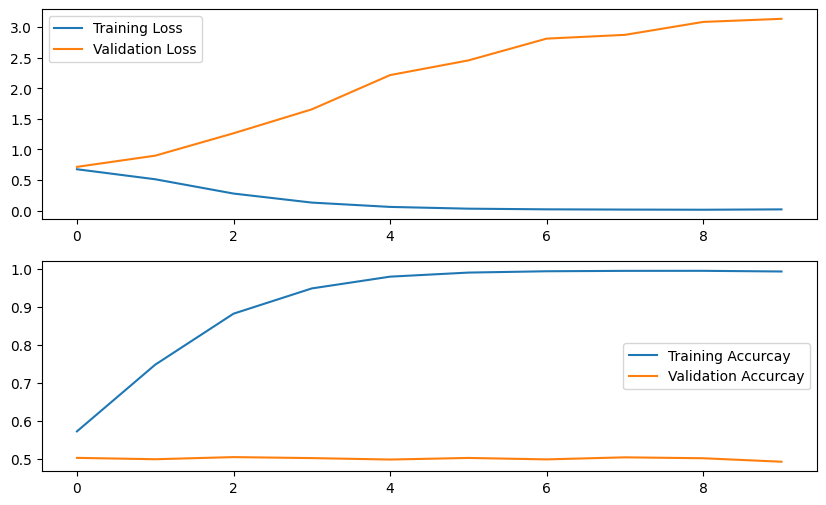

In [3]:
import os
import numpy as np
import pandas as pd
from collections import Counter 
from keras.models import Model
from keras.layers import Input, Embedding, BatchNormalization,  LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger
from preproc import build_vocabulary, Vectorizer 
from plot_utils import plot_history

def get_data ():

     """
     You can get this data from here :
     https://www.kaggle.com/datasets/jayantiprasad/imdb-movies-sentiment
     """
    
     df = pd.read_csv(r"C:\Users\jayanti.prasad\Data\NLP_DATA\train\IMDB_reviews.csv",encoding='utf-8')
     print(df.shape, df.columns)
     return df 


class LSTM_Embedding:
    def __init__(self, output_dir, num_tokens, latent_dim, input_seq_len, num_labels):
        self.num_tokens = num_tokens 
        self.latent_dim = latent_dim 
        self.input_seq_len = input_seq_len 
        self.num_labels = num_labels 
        self.output_dir = output_dir 
        self.get_model()
        
    def get_model (self, ):
         
        encoder_inputs  = Input(shape=(self.input_seq_len,),  name='Input-Layer')
        x = Embedding(self.num_tokens, self.latent_dim, name='Embedding-Layer', mask_zero=False) (encoder_inputs)
        x = BatchNormalization(name='Encoder-Batchnorm-1')(x)

        encoder_outputs, state_h, state_c =  LSTM(latent_dim, return_state=True) (x)

        final_output = Dense(self.num_labels, activation='softmax', name='Final-Output-Dense')(encoder_outputs)
        
        self.model = Model(inputs=encoder_inputs, outputs=final_output, name='Encoder-Model')

        plot_model (self.model)
        plt.show() 
        print(self.model.summary())

    def fit_model (self, X, y, num_epochs):

        model_dir = self.output_dir + os.sep + "trained_model"
        log_dir = self.output_dir + os.sep + "log"
        os.makedirs (model_dir, exist_ok=True)
        os.makedirs (log_dir, exist_ok=True)
        
        chkpt = ModelCheckpoint(filepath=model_dir + os.sep + "model.hdf5",
             save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)

        tboard = TensorBoard(log_dir=log_dir)
        csv_log = CSVLogger(self.output_dir +os.sep + "metrices.csv", separator=",", append=False) 
        
        callbacks = [chkpt, tboard, csv_log]

        self.model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
        history = self.model.fit(X,y,epochs=num_epochs, callbacks=callbacks, validation_split=0.2)
        return history 





if __name__ == "__main__":

    num_tokens  = 1000
    seq_len  = 10
    latent_dim = 60
    num_labels = 2
    output_dir = "tmp_lstm"

    os.makedirs (output_dir,exist_ok=True)
    
    df = get_data()
    corpus = " ".join (df['text'].to_list()) 

    df_vocab  = build_vocabulary (df['text'].to_list())
    df_vocab.to_csv(output_dir + os.sep + "vocab.csv")
    
    V = Vectorizer (df_vocab,10) 
    num_tokens = len (df_vocab [df_vocab['count'] > 10])

    print("num_tokens:",num_tokens) 
  
    input_text_vecs = []
    output_labels = df['label'].to_list()
    for text in df['text'].to_list():
        vec = V.text2vec (text)
        if len (vec) > seq_len:
            input_text_vecs.append (vec[:seq_len]) 
        else:
            vec = vec + [0] * (seq_len - len (vec))
             
    labels = df['label'].to_list()
    input_text_vecs = np.array (input_text_vecs)
    labels = np.array (labels)
    
    M =  LSTM_Embedding (output_dir, num_tokens, latent_dim, seq_len, num_labels)
    plot_model (M.model)
    

    
    history = M.fit_model (input_text_vecs, labels, 10) 

    plot_history (history)


